Importando bibliotecas

In [1]:
import gsidiag as gd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.preprocessing import label_binarize

import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import combinations
from itertools import cycle
import seaborn as sns


Definindo parâmetros para o uso do readDiag

In [3]:
DIRdiag = "/home/patrick/readDiag/data"

varName = "amsua"
varType = "n15"
dateIni="2020010100" 
dateFin="2020010106" 
nHour = "6"          
vminOMA = -2.0       
vmaxOMA = 2.0        
vminSTD = 0.0        
vmaxSTD = 14.0       
Level = 1000
Lay = None           
SingleL = "All" 

datei = datetime.strptime(str(dateIni), "%Y%m%d%H")
datef = datetime.strptime(str(dateFin), "%Y%m%d%H")
dates = [dates.strftime('%Y%m%d%H') for dates in pd.date_range(datei, datef,freq="6H").tolist()]

print(dates)


['2020010100', '2020010106']


Encontrando e listando arquivos para serem usados

In [4]:
paths, pathsc = [], []

OuterL = "01"        
[paths.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterL+"."+dt) for dt in dates]

OuterLc = "03"
[pathsc.append(DIRdiag+"/"+dt+"/diag_amsua_n15_"+OuterLc+"."+dt) for dt in dates]

print(paths)
print("")
print(pathsc)

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106']

['/home/patrick/readDiag/data/2020010100/diag_amsua_n15_03.2020010100', '/home/patrick/readDiag/data/2020010106/diag_amsua_n15_03.2020010106']


Definição da função para discretizar os dados de impacto:

In [5]:
# Função que retorna a categoria:
def categoria_de(valorRF):
    categoria = None
    if valorRF <= -0.25:
        categoria = "Impacto negativo alto"
    elif valorRF > -0.25 and valorRF < 0:
        categoria = "Impacto negativo baixo"
    elif valorRF == 0:
        categoria = "Impacto neutro"
    elif valorRF > 0 and valorRF < 0.25:
        categoria = "Impacto positivo baixo"
    elif valorRF >= 0.25:
        categoria = "Impacto positivo alto"
    return categoria

In [6]:
def train_test_pred_score_RFC(XIS, YPSILOM):
    # Divisão dos dados em conjuntos de treinamento e teste
    X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(XIS, YPSILOM, test_size=0.2, random_state=42)
    X_TRAIN = X_TRAIN.values.reshape(-1, 1)  # Convertendo para formato 2D
    Y_TRAIN = Y_TRAIN.values.reshape(-1, 1)  # Convertendo para formato 2D
    X_TEST = X_TEST.values.reshape(-1, 1)
    Y_TEST = Y_TEST.values.reshape(-1, 1)
    print('Treino e Teste separados')
    print(separator)

    # Inicialização e treinamento do modelo RandomForestClassifier
    MODELO = RandomForestRegressor(max_depth=2, random_state=0)
    MODELO.fit(X_TRAIN, Y_TRAIN)
    print('Modelo treinado!')
    print(separator)

    # Faz previsões usando o modelo treinado nos dados de teste
    Y_PRED = MODELO.predict(X_TEST)
    print('Previsões feitas!')
    print(separator)
    
    return X_TRAIN, X_TEST, Y_TRAIN, Y_TEST, MODELO, Y_PRED

Lendo arquivos listado usando o readDiag e concatenando os dados

In [7]:
# Define uma variável booleana 'read' como True para indicar que a leitura dos arquivos será realizada
read = True

# Verifica se 'read' é True para prosseguir com a leitura dos arquivos
if read:        
    # Inicializa uma lista vazia para armazenar os objetos gdf
    gdf_list = []
    # Imprime uma mensagem informando o tempo estimado necessário para a leitura dos arquivos
    print("")
    print("Aguarde, o tempo total estimado para a leitura dos arquivos é de "+
          str(int((float(len(paths))*20 )/60))+" minutos e "+
          str(int((float(len(paths))*20 )%60))+" segundos.")
    print("")
    # Itera sobre os caminhos dos arquivos e seus caminhos de configuração correspondentes
    for path, pathc in zip(paths,pathsc):
        # Imprime uma mensagem indicando o arquivo que está sendo lido
        print("Reading "+path)
        # Lê o arquivo usando a função read_diag do módulo gsidiag e armazena o objeto retornado em gdf
        gdf = gd.read_diag(path,pathc)
        # Adiciona o objeto gdf à lista gdf_list
        gdf_list.append(gdf)

    # Imprime a lista de objetos gdf lidos
    print(gdf_list)
    
    # Define uma string separadora para uso posterior
    separator = " ====================================================================================================="



Aguarde, o tempo total estimado para a leitura dos arquivos é de 0 minutos e 40 segundos.

Reading /home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
 
>>> GSI DIAG <<<
 
Reading /home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106
 
>>> GSI DIAG <<<
 
[<gsidiag.__main__.read_diag object at 0x7f3dcc3defd0>, <gsidiag.__main__.read_diag object at 0x7f3dd3779510>]


In [8]:
# Inicialização de DataFrame vazio para armazenar dados concatenados
df_concatenado2 = pd.DataFrame()

# Iteração sobre objetos em gdf_list
for objeto in gdf_list:
        
    print(separator)
    print("Separando dados do arquivo" + str(objeto._diagFile))
    
    # Criação de dicionário de dados a partir do objeto   
    dados_dict = {
            'lat': objeto.obsInfo[varName].loc[varType].lat,
            'lon': objeto.obsInfo[varName].loc[varType].lon,
            'elev': objeto.obsInfo[varName].loc[varType].elev,
            'nchan': objeto.obsInfo[varName].loc[varType].nchan,
            'time': objeto.obsInfo[varName].loc[varType].time,
            'iuse': objeto.obsInfo[varName].loc[varType].iuse,
            'idqc': objeto.obsInfo[varName].loc[varType].idqc,
            'inverr': objeto.obsInfo[varName].loc[varType].inverr,
            'oer': objeto.obsInfo[varName].loc[varType].oer,
            'obs': objeto.obsInfo[varName].loc[varType].obs,
            'omf': objeto.obsInfo[varName].loc[varType].omf,
            'omf_nobc': objeto.obsInfo[varName].loc[varType].omf_nobc,
            'emiss': objeto.obsInfo[varName].loc[varType].emiss,
            'oma': objeto.obsInfo[varName].loc[varType].oma,
            'oma_nobc': objeto.obsInfo[varName].loc[varType].oma_nobc,
            'imp': objeto.obsInfo[varName].loc[varType].imp,
            'dfs': objeto.obsInfo[varName].loc[varType].dfs
            }
        
    # Conversão do dicionário em DataFrame
    df_objeto = pd.DataFrame(dados_dict)
    
    # Aplicação da função 'categoria_de' para criar a coluna 'imp_categ'
    df_objeto['imp_categ'] = df_objeto['imp'].apply(categoria_de)
        
    # Concatenação do DataFrame do objeto com o DataFrame concatenado
    df_concatenado2 = pd.concat([df_concatenado2, df_objeto], ignore_index=True)
    

Separando dados do arquivo/home/patrick/readDiag/data/2020010100/diag_amsua_n15_01.2020010100
Separando dados do arquivo/home/patrick/readDiag/data/2020010106/diag_amsua_n15_01.2020010106


In [19]:
# Remoção de linhas com valores NaN
df_concatenado2.dropna(inplace=True)
    
print(df_concatenado2)

print(separator)
    
# Lista de atributos a serem usados para treinamento
atributos = ['nchan', 'omf', 'oma', 'dfs']

# Define as classes do target discretizado para uso posterior
classes = ["Impacto positivo alto", "Impacto positivo baixo", "Impacto negativo baixo", "Impacto negativo alto"]

X = df_concatenado2['obs']
y = df_concatenado2['imp']

              lat         lon         elev  nchan      time  iuse  idqc  \
5      -87.504501   19.704599  2735.045410    6.0  0.315833  -1.0  -0.0   
6      -87.504501   19.704599  2735.045410    7.0  0.315833   1.0   0.0   
7      -87.504501   19.704599  2735.045410    8.0  0.315833   1.0   0.0   
8      -87.504501   19.704599  2735.045410    9.0  0.315833   1.0   0.0   
9      -87.504501   19.704599  2735.045410   10.0  0.315833   1.0   0.0   
...           ...         ...          ...    ...       ...   ...   ...   
209947  77.502502  358.795105    -0.108379    8.0  1.952778   1.0   0.0   
209948  77.502502  358.795105    -0.108379    9.0  1.952778   1.0   0.0   
209949  77.502502  358.795105    -0.108379   10.0  1.952778   1.0   0.0   
209951  77.502502  358.795105    -0.108379   12.0  1.952778   1.0   0.0   
209952  77.502502  358.795105    -0.108379   13.0  1.952778   1.0   0.0   

          inverr       oer         obs       omf  omf_nobc     emiss  \
5       3.557238  0.281441 

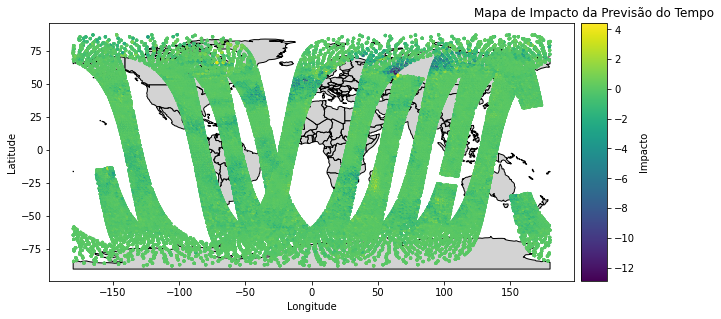

In [20]:
latitude = df_concatenado2['lat']
longitude = df_concatenado2['lon']
impacto = df_concatenado2['imp']

# Ajustando a longitude para o intervalo -180 a 180
longitude_adj = np.where(longitude > 180, longitude - 360, longitude)

# Criando um GeoDataFrame com base nos dados ajustados
gdf = gpd.GeoDataFrame(df_concatenado2, geometry=gpd.points_from_xy(longitude_adj, latitude), crs='EPSG:4326')

# Plotagem
fig, ax = plt.subplots(figsize=(10, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adicionando eixo de cor

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')
scatter = gdf.plot(ax=ax, column='imp', cmap='viridis', markersize=5, legend=True, cax=cax)
scatter.set_xlabel('Longitude')
scatter.set_ylabel('Latitude')
cax.set_ylabel('Impacto')

plt.title('Mapa de Impacto da Previsão do Tempo')
plt.show()

In [21]:
X_train, X_test, y_train, y_test, modelo, y_pred = train_test_pred_score_RFC(X, y)

Treino e Teste separados


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Modelo treinado!
Previsões feitas!


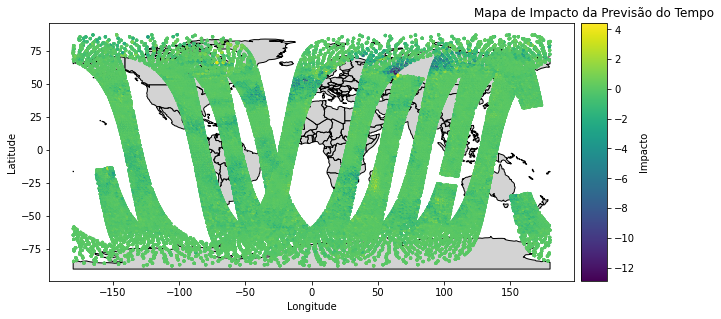

In [22]:
latitude = df_concatenado2['lat']
longitude = df_concatenado2['lon']
impacto = y_pred

# Ajustando a longitude para o intervalo -180 a 180
longitude_adj = np.where(longitude > 180, longitude - 360, longitude)

# Criando um GeoDataFrame com base nos dados ajustados
gdf = gpd.GeoDataFrame(df_concatenado2, geometry=gpd.points_from_xy(longitude_adj, latitude), crs='EPSG:4326')

# Plotagem
fig, ax = plt.subplots(figsize=(10, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adicionando eixo de cor

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')
scatter = gdf.plot(ax=ax, column='imp', cmap='viridis', markersize=5, legend=True, cax=cax)
scatter.set_xlabel('Longitude')
scatter.set_ylabel('Latitude')
cax.set_ylabel('Impacto')

plt.title('Mapa de Impacto da Previsão do Tempo')
plt.show()

In [ ]:
latitude = df_concatenado2['lat']
longitude = df_concatenado2['lon']
impacto = y_pred

# Ajustando a longitude para o intervalo -180 a 180
longitude_adj = np.where(longitude > 180, longitude - 360, longitude)

# Criando um GeoDataFrame com base nos dados ajustados
gdf = gpd.GeoDataFrame(df_concatenado2, geometry=gpd.points_from_xy(longitude_adj, latitude), crs='EPSG:4326')

# Plotagem
fig, ax = plt.subplots(figsize=(10, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # Adicionando eixo de cor

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='lightgrey', edgecolor='black')
scatter = gdf.plot(ax=ax, column='imp', cmap='viridis', markersize=5, legend=True, cax=cax)
scatter.set_xlabel('Longitude')
scatter.set_ylabel('Latitude')
cax.set_ylabel('Impacto')

plt.title('Mapa de Impacto da Previsão do Tempo')
plt.show()

In [13]:
#SCORE = modelo.score(X, y, sample_weight=None)
#print(f"Coeficiente de determinação da previsão (Score - R^2): ",SCORE)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Calcula R-quadrado
r2 = r2_score(y_test, y_pred)
print(f"R^2 = ",r2)

# Calcula MSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE = ",mse)

# Calcula MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE = ",mae)

R^2 =  0.00529308457491251
MSE =  0.21084116001578618
MAE =  0.2605110476344757


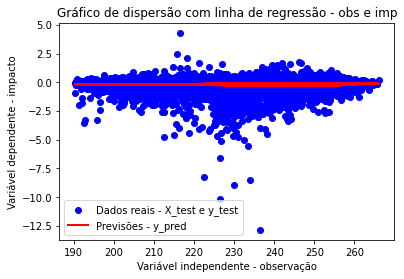

In [14]:
import matplotlib.pyplot as plt

# Plotagem dos dados reais
plt.scatter(X_test, y_test, color='blue', label='Dados reais - X_test e y_test')

# Plotagem das previsões
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Previsões - y_pred')

plt.xlabel('Variável independente - observação')
plt.ylabel('Variável dependente - impacto')
plt.title('Gráfico de dispersão com linha de regressão - obs e imp')
plt.legend()
plt.show()

[6, 7, 8, 9, 10, 12, 13]
Treino e Teste separados


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Modelo treinado!
Previsões feitas!


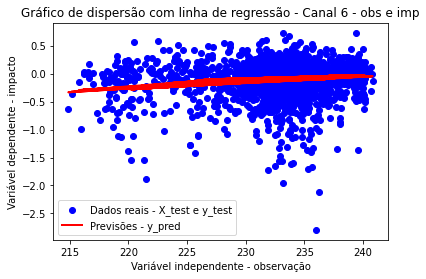

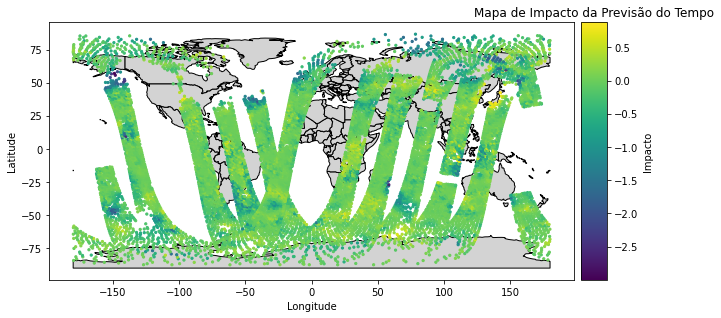

Treino e Teste separados
Modelo treinado!


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Previsões feitas!


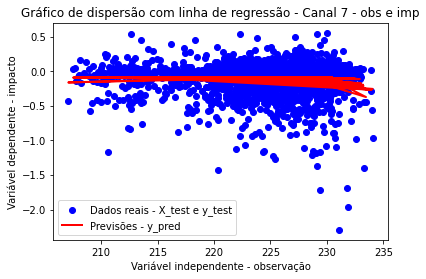

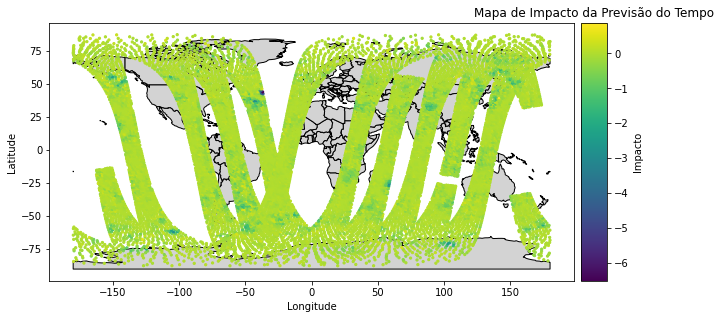

Treino e Teste separados


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Modelo treinado!
Previsões feitas!


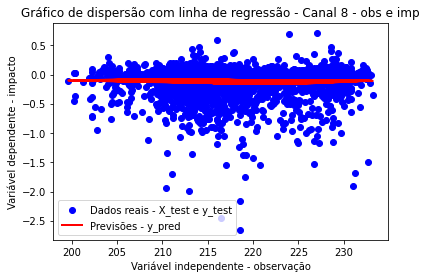

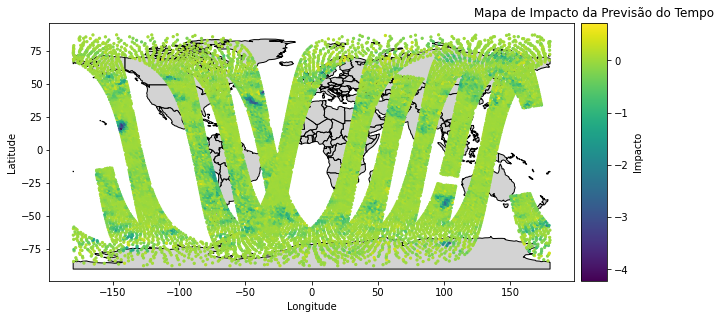

Treino e Teste separados


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Modelo treinado!
Previsões feitas!


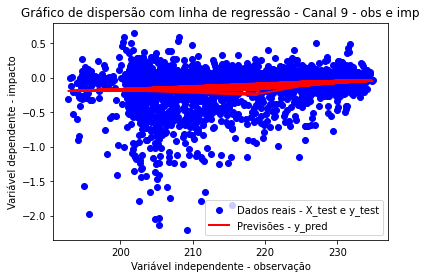

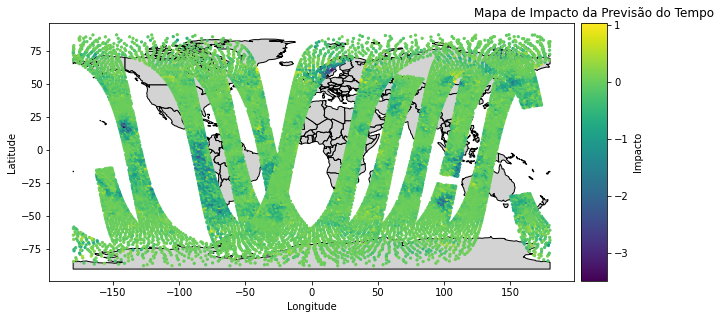

Treino e Teste separados


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Modelo treinado!
Previsões feitas!


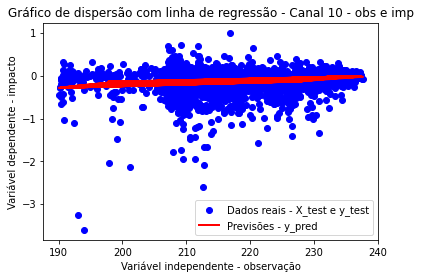

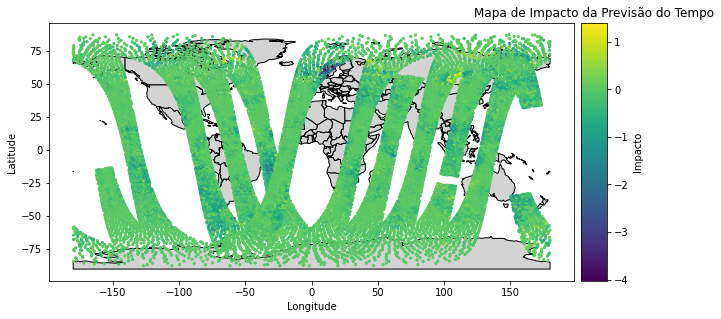

Treino e Teste separados


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Modelo treinado!
Previsões feitas!


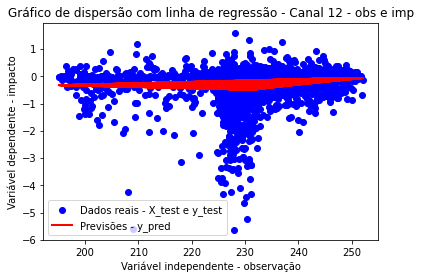

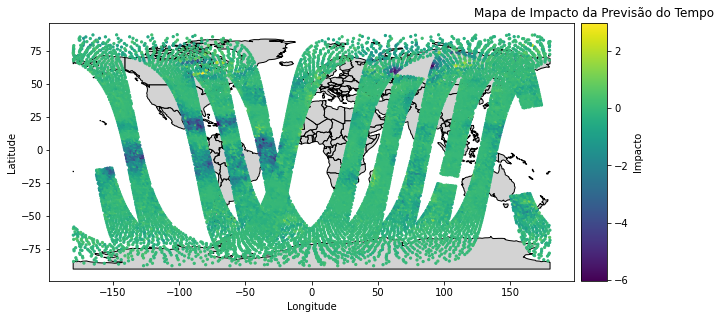

Treino e Teste separados


/home/patrick/anaconda3/envs/readDiag/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


Modelo treinado!
Previsões feitas!


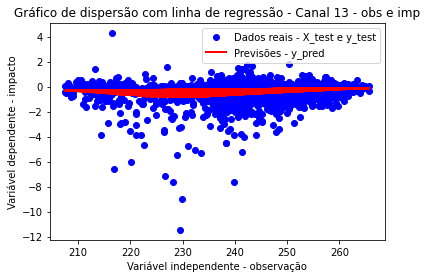

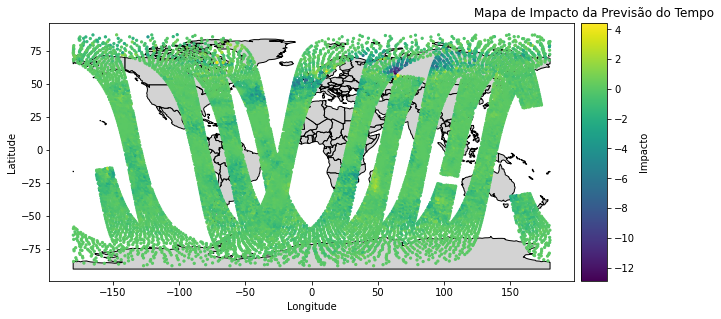

In [18]:
# Supondo que 'df' seja o seu DataFrame e 'canal' seja a coluna que contém os canais de radiância
#canais = df_concatenado2['nchan'].unique()  # Obtém a lista de canais únicos
canais = [6, 7, 8, 9, 10, 12, 13] #Canais que contém bons dados

# Imprime a lista de canais únicos
print(canais)

# Lista para armazenar modelos de cada canal e resultados
modeloscanais = []
resultados = []

for canal in canais:
    tipo = f"Canal {canal}"
    
    # Divida o DataFrame para o canal atual
    df_canal = pd.DataFrame()
    df_canal = df_concatenado2[df_concatenado2['nchan'] == canal]
    
    # Separe os recursos (X) e o alvo (y)
    X = df_canal['obs']
    y = df_canal['imp']
        
    # Divida os dados em conjuntos de treinamento e teste
    
    X_train, X_test, y_train, y_test, modeloch, y_pred = train_test_pred_score_RFC(X, y)
    # Adicionando modelo para o canal atual em uma lista
    nome_modelo = f"modeloch{canal}"
    modeloscanais.append((nome_modelo, modeloch))
    
    # Plotagem dos dados reais
    plt.scatter(X_test, y_test, color='blue', label='Dados reais - X_test e y_test')

    # Plotagem das previsões
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Previsões - y_pred')

    plt.xlabel('Variável independente - observação')
    plt.ylabel('Variável dependente - impacto')
    plt.title(f'Gráfico de dispersão com linha de regressão - Canal {canal} - obs e imp')
    plt.legend()
    plt.show()
    
    latitude = df_canal['lat']
    longitude = df_canal['lon']
    impacto = df_canal['imp']

    # Ajustando a longitude para o intervalo -180 a 180
    longitude_adj = np.where(longitude > 180, longitude - 360, longitude)

    # Criando um GeoDataFrame com base nos dados ajustados
    gdf = gpd.GeoDataFrame(df_canal, geometry=gpd.points_from_xy(longitude_adj, latitude), crs='EPSG:4326')

    # Plotagem
    fig, ax = plt.subplots(figsize=(10, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Adicionando eixo de cor

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')
    scatter = gdf.plot(ax=ax, column='imp', cmap='viridis', markersize=5, legend=True, cax=cax)
    scatter.set_xlabel('Longitude')
    scatter.set_ylabel('Latitude')
    cax.set_ylabel('Impacto')

    plt.title('Mapa de Impacto da Previsão do Tempo')
    plt.show()
    

In [ ]:
# Supondo que 'df' seja o seu DataFrame e 'canal' seja a coluna que contém os canais de radiância
#canais = df_concatenado2['nchan'].unique()  # Obtém a lista de canais únicos
canais = [6, 7, 8, 9, 10, 12, 13] #Canais que contém bons dados

# Imprime a lista de canais únicos
print(canais)

# Lista para armazenar modelos de cada canal e resultados
modeloscanais = []
resultados = []

for canal in canais:
    tipo = f"Canal {canal}"
    
    # Divida o DataFrame para o canal atual
    df_canal = pd.DataFrame()
    df_canal = df_concatenado2[df_concatenado2['nchan'] == canal]
    
    # Separe os recursos (X) e o alvo (y)
    X = df_canal['obs']
    y = df_canal['imp']
        
    # Divida os dados em conjuntos de treinamento e teste
    
    X_train, X_test, y_train, y_test, modeloch, y_pred = train_test_pred_score_RFC(X, y)
    # Adicionando modelo para o canal atual em uma lista
    nome_modelo = f"modeloch{canal}"
    modeloscanais.append((nome_modelo, modeloch))
    
    # Plotagem dos dados reais
    plt.scatter(X_test, y_test, color='blue', label='Dados reais - X_test e y_test')

    # Plotagem das previsões
    plt.plot(X_test, y_pred, color='red', linewidth=2, label='Previsões - y_pred')

    plt.xlabel('Variável independente - observação')
    plt.ylabel('Variável dependente - impacto')
    plt.title(f'Gráfico de dispersão com linha de regressão - Canal {canal} - obs e imp')
    plt.legend()
    plt.show()
    
    latitude = df_canal['lat']
    longitude = df_canal['lon']
    impacto = df_canal['imp']

    # Ajustando a longitude para o intervalo -180 a 180
    longitude_adj = np.where(longitude > 180, longitude - 360, longitude)

    # Criando um GeoDataFrame com base nos dados ajustados
    gdf = gpd.GeoDataFrame(df_canal, geometry=gpd.points_from_xy(longitude_adj, latitude), crs='EPSG:4326')

    # Plotagem
    fig, ax = plt.subplots(figsize=(10, 6))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  # Adicionando eixo de cor

    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')
    scatter = gdf.plot(ax=ax, column='imp', cmap='viridis', markersize=5, legend=True, cax=cax)
    scatter.set_xlabel('Longitude')
    scatter.set_ylabel('Latitude')
    cax.set_ylabel('Impacto')

    plt.title('Mapa de Impacto da Previsão do Tempo')
    plt.show()
    